In [2]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import cv2
from commonfunctions import *
from stemRemoval import stemRemoval
from skimage.util import img_as_ubyte
from skimage.measure import label, regionprops
from skimage.draw import rectangle_perimeter

In [4]:
# custom split_objects (same as original but returns the stafflineSpacing)
def test_split_objects(img_thresh):
    img_objects , staffLines = staffLineRemoval(img_thresh, 1)
    height = img_objects.shape[0]
    count_blocks = len(staffLines) // 5
    
    if count_blocks > 1: 
        padding_up = (staffLines[5] - staffLines[4]) // 2 
        padding_down = padding_up 
    else:
        padding_up = staffLines[0]
        padding_down =  height - staffLines[4]

    blocks = []
    blocks_orginal = []
    for i in range(0 , count_blocks):
        if i == 0:
            blocks.append(img_objects[0: staffLines[i * 5 + 4] + padding_down,:])
            blocks_orginal.append(img_thresh[0: staffLines[i * 5 + 4] + padding_down,:])
        elif i == count_blocks - 1:
            blocks.append(img_objects[staffLines[i * 5] - padding_up: height ,:])            
            blocks_orginal.append(img_thresh[staffLines[i * 5] - padding_up: height ,:])            
        else:
            blocks.append(img_objects[staffLines[i * 5] - padding_up: staffLines[i * 5 + 4] + padding_down,:])
            blocks_orginal.append(img_thresh[staffLines[i * 5] - padding_up: staffLines[i * 5 + 4] + padding_down,:])
    
    staffHeight = staffLines[4] - staffLines[3]
    
    objects = []
    # TODO: temporary solution add an array to store for each block the starting staffline
    top_block_staffLine = []
    for i  in  range(count_blocks):
        contours, hier = cv2.findContours(255 - blocks[i], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnt = []
        for j in range (0, len(contours)):
            if hier[0,j,3] == -1:
                cnt.append(contours[j])
        cnt, boxes_sorted = sort_contours_horizontally(cnt)        
        for c in cnt:
            Xmin = int(np.min(c[:,0, 0]))
            Xmax = int(np.max(c[:,0, 0]))
            Ymin = int(np.min(c[:,0, 1]))
            Ymax = int(np.max(c[:,0, 1]))

            object_width = Xmax - Xmin
            object_height = Ymax - Ymin
            if object_width > staffHeight//2: 
                current_obj = blocks[i][Ymin:Ymax, Xmin:Xmax]
                objects.append(current_obj)  
            elif object_height <= staffHeight//2:
                point_img = np.ones((blocks[i].shape[0],15))
                point_img[blocks[i].shape[0]//2-3:blocks[i].shape[0]//2+3, 5:10] = 0
                objects.append(point_img)
            top_block_staffLine.append(i)   
    return (objects, staffLines, top_block_staffLine, staffHeight)

In [5]:
img = rgb2gray(io.imread('dataset/scanned/08.PNG'))
noisy_img = img_as_ubyte(img)
img_median_filtered = hybridMedian(noisy_img)
img_median_filtered = img_median_filtered.astype(np.uint8)
# img_median_filtered = median(noisy_img)
# gaussian filtering
img_gaussian_filtered = gaussian(img_median_filtered, sigma=0.2)
img_gaussian_filtered = (img_gaussian_filtered * 255).astype(np.uint8)

# image rotation
image_rotated = skew_angle_hough_transform(img_gaussian_filtered)
image_rotated = (image_rotated * 255).astype(np.uint8)

# image binarization
binary = adaptiveThresh(image_rotated, t=15, div=8)

objects, staffLines, top_block_staffLine, staffLineSpacing = test_split_objects(binary)
# print(staffLineSpacing)


In [32]:
print(staffLineSpacing)
print(staffLines)
# def classify_beams():
print(regions_v)
print(bboxes)
print(bboxes_centroids)


49
[ 94 142 192 240 289]
[((310, 45, 311, 49), (310.0, 46.5)), ((321, 38, 330, 87), (324.97058823529414, 62.37908496732026))]
[(310, 45, 311, 49), (321, 38, 330, 87)]
[(310.0, 46.5), (324.97058823529414, 62.37908496732026)]


stems (positions, widths) found:  [(42, 14), (87, 1), (90, 2)]
The number of labels : 6
(321, 38, 330, 87)
The notes are above the beam


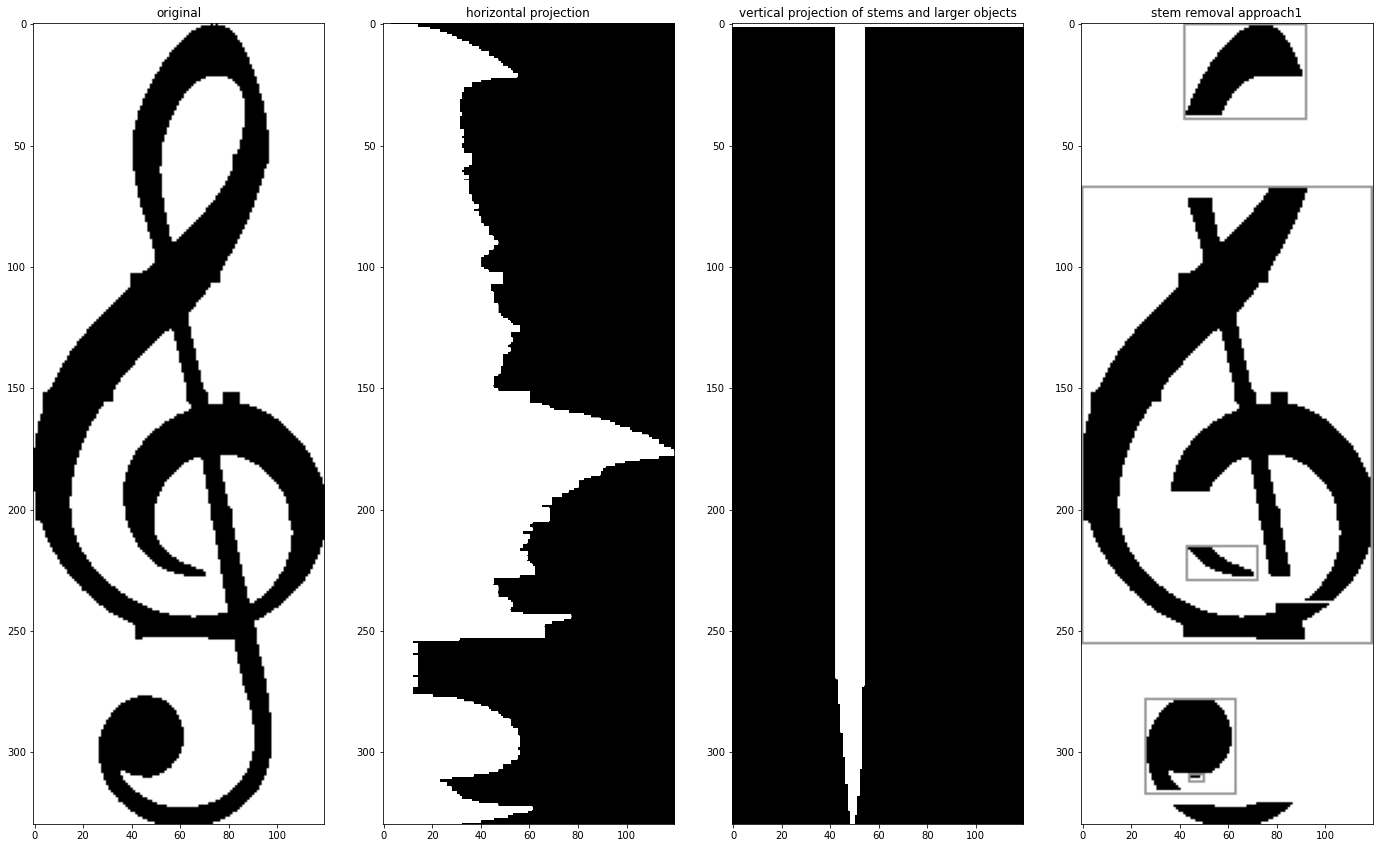

stems (positions, widths) found:  [(74, 7), (231, 6)]
The number of labels : 3
(245, 0, 293, 99)
The beam is above the notes
pos : 3.0
pos : 1.0


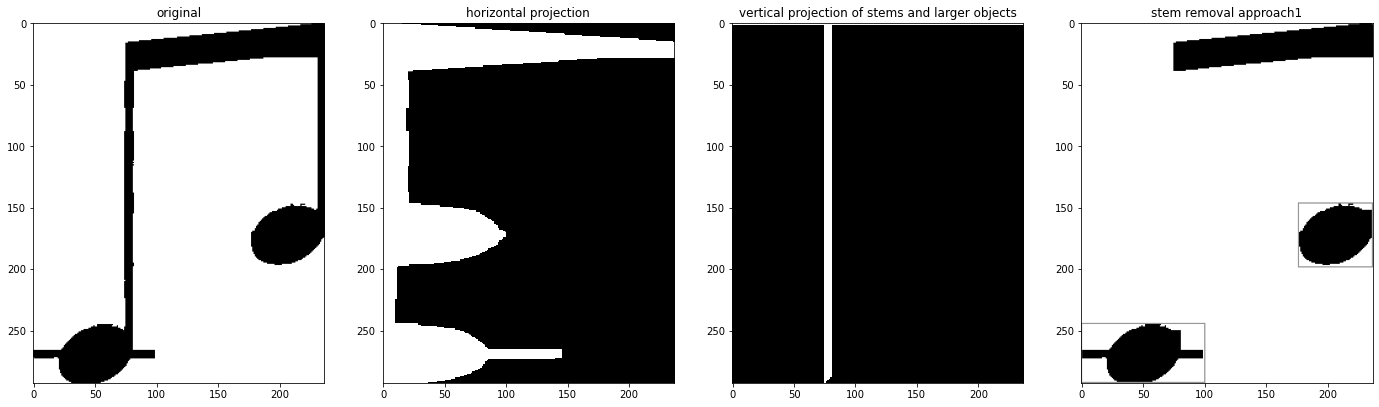

stems (positions, widths) found:  [(53, 7), (210, 6)]
The number of labels : 3
(170, 0, 222, 60)
The beam is above the notes
pos : 2.0
pos : 1.0


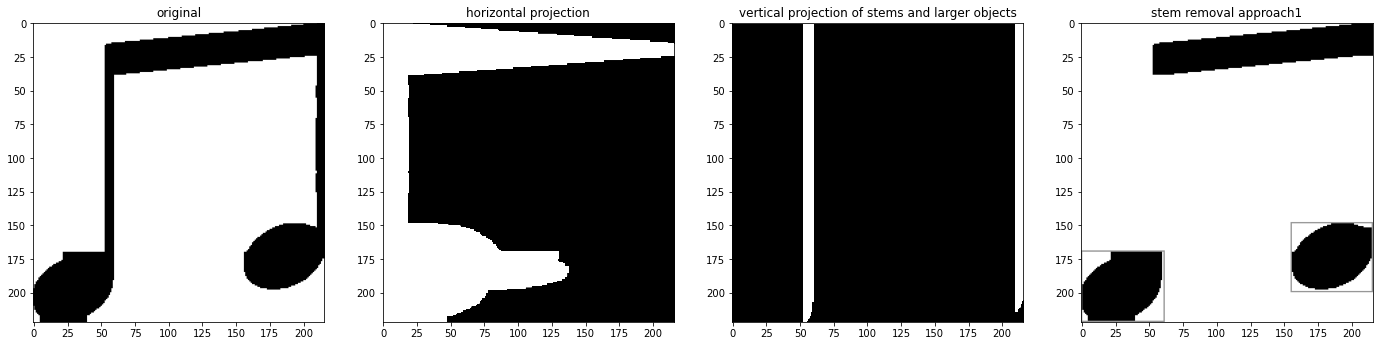

In [37]:
cnt_obj = -1
for object in objects:
    cnt_obj = cnt_obj + 1
    # staffLineSpacing = 20
    testNoStem, stems = stemRemoval(object, staffLineSpacing)

    # BEAM CLASSIFICATION
    num_stems = len(stems)
    if num_stems > 1:
        print('stems (positions, widths) found: ', stems)
        orig = np.copy(object)
        object = 255 - object
        height, width = object.shape
        # check if it the beam is above or below the note heads
        rectL_sum = np.sum(object[:, :staffLineSpacing//2])
        rectR_sum = np.sum(object[:, width-(staffLineSpacing//2): width])
        labeled_img, num_labels = label(testNoStem-255, background=0, return_num=True, connectivity=2)
        print("The number of labels : " + str(num_labels))
        regions = regionprops(labeled_img)

        # horizontal projection for the objects with no stem
        No_Stem_horiz_proj = (np.sum((255-testNoStem)/255, axis=1)).astype('uint32')
        # visualize the bounding boxes
        bboxes = []
        bboxes_centroids = []
        for region in regions:
            rect_endpoints = region['bbox']
            # get bounding box coordinates
            min_row = rect_endpoints[0]
            min_col = rect_endpoints[1]
            max_row = rect_endpoints[2]
            max_col = rect_endpoints[3]
            bbox_width = max_col - min_col
            # print('w : ' + str(bbox_width))
            bbox_height = max_row - min_row
            # print('h : ' + str(bbox_height))
            # filter the noteheads from the beams
            if rectL_sum > rectR_sum:
                beam_max_row = np.nonzero(No_Stem_horiz_proj)[0][-1]
                if max_row < beam_max_row:
                    bboxes.append(rect_endpoints)
                    bboxes_centroids.append(region['centroid'])
            else:
                beam_min_row = np.nonzero(No_Stem_horiz_proj)[0][0]
                if min_row > beam_min_row:
                    bboxes.append(rect_endpoints)
                    bboxes_centroids.append(region['centroid'])

        print(rect_endpoints)
        for rect_endpoints in bboxes:
            rect_start = (rect_endpoints[0], rect_endpoints[1])
            rect_end = (rect_endpoints[2], rect_endpoints[3])
            rr, cc = rectangle_perimeter(rect_start, rect_end, shape=object.shape,clip=True)
            testNoStem[rr, cc] = 150
            
        #classify
        if rectL_sum > rectR_sum:
            print("The notes are above the beam")
        #TODO: remember to check if the equal condition can cause problems or if it is possible to happen at all
        else:
            print("The beam is above the notes")
            bboxes_centroids.sort(key=lambda x:x[1])
            for centroid in bboxes_centroids:
                cent_y = centroid[0]
                top_staff_y = staffLines[top_block_staffLine[cnt_obj]]
                print('pos : ' + str((cent_y - top_staff_y) // staffLineSpacing))
        horiz_proj = (np.sum(object/255, axis=1)).astype('uint32')
        vert_proj = (np.sum(object/255, axis=0)).astype('uint32')
        # visualize the horizontal projection
        m = np.max(horiz_proj, initial=0)
        if m == 0:
            m = 1
        result = np.zeros((height,width))
        # Draw a line for each row
        for row in range(height):
            cv2.line(result, (0,row), (int(horiz_proj[row]*width/m),row), 255, 1)

        # visualize the vertical projection
        m = np.max(vert_proj, initial=0)
        if m == 0:
            m = 1
        result2 = np.zeros((height, width))
        
        # thresholding to remove non stems from the image in the vertical projection for visualisation
        max_vertical = 0.8 * m
        vert_proj = np.where(vert_proj <= max_vertical, 0, vert_proj)
        mask = np.where(vert_proj!=0, 1, 0)
        # Draw a line for each row
        for col in range(width):
            cv2.line(result2, (col,0), (col,int(vert_proj[col]*height/m)), 255, 1)

        show_images([orig, result, result2, testNoStem], ['original', 'horizontal projection', 'vertical projection of stems and larger objects', 'stem removal approach1'])

In [41]:
import matplotlib.pyplot as plt
from matplotlib import cm

def tstaffLineRemoval(thresholdedImg, thicknessThresholdFraction):
    img = np.copy(thresholdedImg)  # for convinience :)
    height, width = img.shape
    # Invert the input binary image
    imgBinary = 255 - img

    # apply hough lines to detect stafflines
    hspace, angles, dists = hough_line(imgBinary)
    hspac, angle, distan = hough_line_peaks(hspace, angles, dists)
    filtered_dists = []
    # ---------------------------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(thresholdedImg, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    ax[1].imshow(np.log(1 + hspace),
                extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), dists[-1], dists[0]],
                cmap=cm.gray, aspect=1/1.5)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    ax[2].imshow(thresholdedImg, cmap=cm.gray)
    origin = np.array((0, thresholdedImg.shape[1]))
    for _, angle, dist in zip(*hough_line_peaks(hspace, angles, dists)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        ax[2].plot(origin, (y0, y1), '-r')
    ax[2].set_xlim(origin)
    ax[2].set_ylim((thresholdedImg.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    plt.tight_layout()
    plt.show()
    # ---------------------------------------------------------------------------
    staffLines = np.sort(np.round(distan).astype('int32'))
    # remove negative staffLines 
    staffLines = staffLines[staffLines >= 0]
    print('staffLines from staffLineRemoval : ' + str(staffLines))
    # find most common black pixel run length (white pixel run length in binary image due to inversion)
    # This should correspond to staff line thickness
    staffLineThickness = verticalRunLengthMode(imgBinary, 255, width, height)
    # TODO: check whether the addition is needed
    staffLineSpacing = verticalRunLengthMode(imgBinary, 0, width, height)

    threshold = staffLineSpacing / 2  # TODO: check whether needed
    for staffLineRow in staffLines:
        for x in range(width-1, 0, -1):
            if img[staffLineRow, x] != 0:
                for j in range(1, round(threshold/2)):
                    if img[staffLineRow + j, x] == 0:
                        staffLineRow = staffLineRow + j
                        break
                    if img[staffLineRow - j, x] == 0:
                        staffLineRow = staffLineRow - j
                        break
            verticalThresholdResult = testVerticalThreshold(
                img, x, staffLineRow, staffLineThickness*thicknessThresholdFraction)
            if(verticalThresholdResult[0]):
                rr, cc = line(
                    verticalThresholdResult[1], x, verticalThresholdResult[2], x)
                img[rr, cc] = 150
        # TODO: fix with morphology the broken objects
    return (img, staffLines)


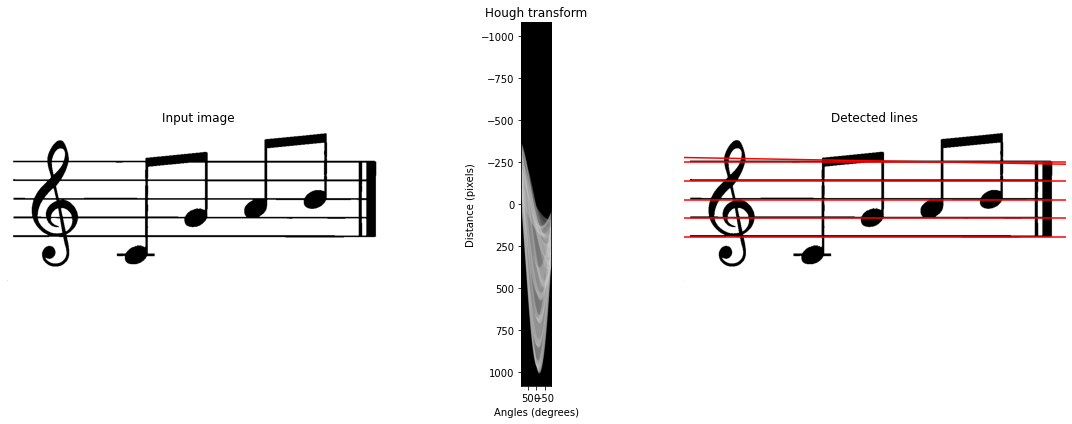

staffLines from staffLineRemoval : [ 94 142 192 240 289]


NameError: name 'verticalRunLengthMode' is not defined

In [42]:


img = rgb2gray(io.imread('dataset/scanned/08.PNG'))
# noisy_img = random_noise(img, mode='s&p', amount=0.1)
# noisy_img = (noisy_img * 255).astype(np.uint8)
# Median filtering using the hybrid Median filter
img_gray = img
if img_gray.dtype != np.uint8:
    img_gray = (img_gray * 255).astype(np.uint8)

img_median_filtered = (hybridMedian(img_gray)).astype(np.uint8)

# gaussian filtering
img_gaussian_filtered = (gaussian(img_median_filtered, sigma=0.2)* 255).astype(np.uint8)

image_rotated = (skew_angle_hough_transform(img_gaussian_filtered)* 255).astype(np.uint8)
# image binarization
binary = adaptiveThresh(image_rotated, t=15, div=8)
# image rotation

# show_images([img, img_gray, img_median_filtered, img_gaussian_filtered, binary, image_rotated])

# staff line removal
image_no_staff, stuff = tstaffLineRemoval(binary, 1)
show_images([image_no_staff])
print(stuff)